API Documentation: https://developer.ebay.com/devzone/finding/callref/finditemsadvanced.html

In [1]:
import requests
from bs4 import BeautifulSoup
from ebaysdk.finding import Connection
import json
import pandas as pd
import xmltodict
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

In [2]:
#Help from: https://stackoverflow.com/questions/56517453/increase-amount-of-item-search-result-via-ebay-api-python
api = Connection(appid='USE YOUR OWN APP-ID FROM THE EBAY DEV WEBSITE!!!', config_file=None)
#Could make this API used for any listing.
#search = str(input('What do you want to search?'))
#Look into https://github.com/timotheus/ebaysdk-python/issues/142

#Set up request parameters for the API.
#HUGE credit to https://github.com/timotheus/ebaysdk-python/issues/267
#for helping how to format parameters.

items = []

for page in range(1, 5):
    api_request = {
        'keywords': 'rtx 4090',
        #'itemFilter' : [{'name': 'condition', 'value': 'New'}]
        'paginationInput': {
                    'entriesPerPage': 100,
                    'pageNumber': page
                },
        'outputSelector': ['SellerInfo'],
    }
    response = api.execute('findItemsAdvanced', api_request)
    soup = BeautifulSoup(response.content, features='xml')
    items += (soup.find_all("item"))
print(soup)

<?xml version="1.0" encoding="utf-8"?>
<findItemsAdvancedResponse xmlns="http://www.ebay.com/marketplace/search/v1/services"><ack>Success</ack><version>1.13.0</version><timestamp>2023-12-23T22:41:33.797Z</timestamp><searchResult count="100"><item><itemId>325586006496</itemId><title>Bracket For ZOTAC NVIDIA GeForce RTX4090 AMP EXTREME AIRO Graphics Video Card</title><globalId>EBAY-US</globalId><primaryCategory><categoryId>27386</categoryId><categoryName>Graphics/Video Cards</categoryName></primaryCategory><galleryURL>https://i.ebayimg.com/thumbs/images/g/2f4AAOSwRcxkmQQ5/s-l140.jpg</galleryURL><viewItemURL>https://www.ebay.com/itm/Bracket-ZOTAC-NVIDIA-GeForce-RTX4090-AMP-EXTREME-AIRO-Graphics-Video-Card-/325586006496</viewItemURL><autoPay>false</autoPay><location>China</location><country>CN</country><sellerInfo><sellerUserName>cat-buyer_5</sellerUserName><feedbackScore>668</feedbackScore><positiveFeedbackPercent>99.6</positiveFeedbackPercent><feedbackRatingStar>Purple</feedbackRatingSta

In [3]:
#Convert XML results to a string & store them in a list
items_str = []
for i in items:
    i = str(i)
    items_str.append(i)
#items_str

In [4]:
#Convert XML to Dict and build a JSON inside a list
json_final = []
for i in range(len(items_str)):
    xml_j = xmltodict.parse(items_str[i])
    #print(j)
    json_final.append(xml_j)

In [5]:
json_final

[{'item': {'itemId': '134859854115',
   'title': 'NIB  ASUS ROG Strix NVIDIA GeForce RTX 4090 24GB GDDR6X Gaming Graphics Card',
   'globalId': 'EBAY-US',
   'primaryCategory': {'categoryId': '27386',
    'categoryName': 'Graphics/Video Cards'},
   'galleryURL': 'https://i.ebayimg.com/thumbs/images/g/--IAAOSwfVxlg3lF/s-l140.jpg',
   'viewItemURL': 'https://www.ebay.com/itm/NIB-ASUS-ROG-Strix-NVIDIA-GeForce-RTX-4090-24GB-GDDR6X-Gaming-Graphics-Card-/134859854115',
   'productId': {'@type': 'ReferenceID', '#text': '14058200453'},
   'autoPay': 'false',
   'postalCode': '925**',
   'location': 'Homeland,CA,USA',
   'country': 'US',
   'sellerInfo': {'sellerUserName': 'bilboz_breakz',
    'feedbackScore': '11',
    'positiveFeedbackPercent': '100.0',
    'feedbackRatingStar': 'Yellow',
    'topRatedSeller': 'false'},
   'shippingInfo': {'shippingServiceCost': {'@currencyId': 'USD',
     '#text': '0.0'},
    'shippingType': 'Free',
    'shipToLocations': 'Worldwide',
    'expeditedShipping'

In [6]:
len(json_final)

400

In [7]:
titlelist = []
plist = []
sellerloc = []
sellerRating = []
feedbackpct = []
toprated = []
condition = []

#Extraction test
for i in range(len(json_final)):
    #Variable to shortern for loop
    find = json_final[i]['item']
    
    titlelist.append(find['title'])
   # print(i['sellingStatus']['convertedCurrentPrice']['#text'])
    plist.append(float(find['sellingStatus']['convertedCurrentPrice']['#text']))
    sellerloc.append(find['location'])
    #print(i['location'])
    sellerRating.append(find['sellerInfo']['feedbackScore'])
    feedbackpct.append(find['sellerInfo']['positiveFeedbackPercent'])
    toprated.append(find['sellerInfo']['topRatedSeller'])
    try:
        condition.append(find['condition']['conditionId'])
    except:
        condition.append(7000)
len(titlelist)

400

In [8]:
'''
for i in range(len(toprated)):
    if toprated[i] == 'true':
        toprated[i] = 1
    else:
        toprated[i] = 0
'''

"\nfor i in range(len(toprated)):\n    if toprated[i] == 'true':\n        toprated[i] = 1\n    else:\n        toprated[i] = 0\n"

In [9]:
dict_ = {
    'Product': titlelist,
    'Price (in USD)': plist,
    'Product Condition' : condition,
    'Seller Location' : sellerloc,
    'Feedback Score' : sellerRating,
    'Positive Feedback %' : feedbackpct,
    'Top Rated Seller?' : toprated,
}

In [10]:
'''
#Creating conditions that determine a fradulent seller

fraud = []
for i in range(len(json_final)):
    fraud.append(0)
print(fraud)

avg_price = sum(plist)/len(plist)

counter = 0
for i in plist:
    if i > (avg_price + 300) or i < (avg_price - 400):
        fraud[counter] = 1
    counter += 1

counter = 0
for i in condition:
    try:
        if i > 5001:
            fraud[counter] = 1
        counter += 1
    except:
        counter += 1

counter = 0
for i in sellerRating:
    try:
        if i < 30:
            fraud[counter] = 1
        counter += 1
    except:
        counter += 1
        
counter = 0
for i in feedbackpct:
    try:
        if i < 98:
            fraud[counter] = 1
        counter += 1
    except:
        counter += 1
print(fraud)
'''

'\n#Creating conditions that determine a fradulent seller\n\nfraud = []\nfor i in range(len(json_final)):\n    fraud.append(0)\nprint(fraud)\n\navg_price = sum(plist)/len(plist)\n\ncounter = 0\nfor i in plist:\n    if i > (avg_price + 300) or i < (avg_price - 400):\n        fraud[counter] = 1\n    counter += 1\n\ncounter = 0\nfor i in condition:\n    try:\n        if i > 5001:\n            fraud[counter] = 1\n        counter += 1\n    except:\n        counter += 1\n\ncounter = 0\nfor i in sellerRating:\n    try:\n        if i < 30:\n            fraud[counter] = 1\n        counter += 1\n    except:\n        counter += 1\n        \ncounter = 0\nfor i in feedbackpct:\n    try:\n        if i < 98:\n            fraud[counter] = 1\n        counter += 1\n    except:\n        counter += 1\nprint(fraud)\n'

In [11]:
'''
dict_ = {
    'Product': titlelist,
    'Price (in USD)': plist,
    'Product Condition' : condition,
    'Seller Location' : sellerloc,
    'Feedback Score' : sellerRating,
    'Positive Feedback %' : feedbackpct,
    'Top Rated Seller?' : toprated,
    'Fraud' : fraud
}

df = pd.DataFrame(dict_)
df
'''

"\ndict_ = {\n    'Product': titlelist,\n    'Price (in USD)': plist,\n    'Product Condition' : condition,\n    'Seller Location' : sellerloc,\n    'Feedback Score' : sellerRating,\n    'Positive Feedback %' : feedbackpct,\n    'Top Rated Seller?' : toprated,\n    'Fraud' : fraud\n}\n\ndf = pd.DataFrame(dict_)\ndf\n"

In [12]:
#Product Condition translator:
#A better quality product has a LOWER rating

In [13]:
df = pd.DataFrame(dict_)

In [14]:
for column in df.columns:
    df[column] = df[column].apply(lambda x: pd.to_numeric(x, errors = 'ignore'))
#pd.to_numeric(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Product              400 non-null    object 
 1   Price (in USD)       400 non-null    float64
 2   Product Condition    400 non-null    int64  
 3   Seller Location      400 non-null    object 
 4   Feedback Score       400 non-null    int64  
 5   Positive Feedback %  400 non-null    float64
 6   Top Rated Seller?    400 non-null    object 
dtypes: float64(2), int64(2), object(3)
memory usage: 22.0+ KB


In [15]:
df.describe()

,Price (in USD),Product Condition,Feedback Score,Positive Feedback %
count,400.000000,400.000000,400.000000,400.000000
mean,2614.592025,1548.950000,2962.752500,86.561500
std,5927.665658,1286.981624,8856.354824,32.677292
min,9.180000,1000.000000,0.000000,0.000000
25%,2014.962500,1000.000000,49.500000,98.150000
50%,2249.995000,1000.000000,231.500000,100.000000
75%,2599.000000,1500.000000,1535.250000,100.000000
max,118500.000000,7000.000000,111020.000000,100.000000


In [16]:
#df.to_csv('RTX4090_RobertNeagu.csv')

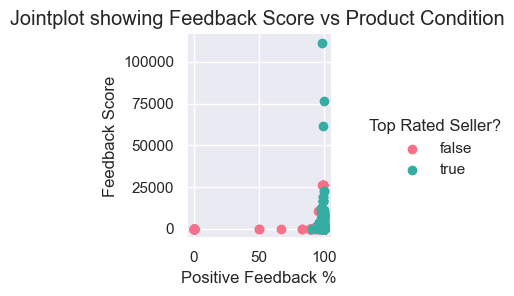

In [17]:
sns.set(color_codes = True)
import warnings
warnings.filterwarnings("ignore")

rp=sns.FacetGrid(df, hue='Top Rated Seller?', palette='husl').map(plt.scatter, 'Positive Feedback %', 'Feedback Score').add_legend()
rp.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
rp.fig.suptitle('Jointplot showing Feedback Score vs Product Condition')
plt.show()

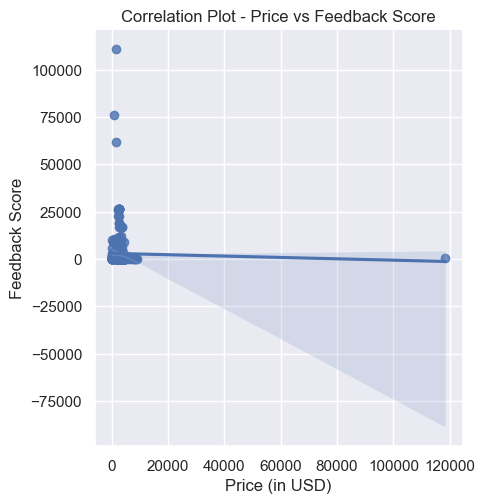

In [18]:
#Correlation Plot
sns.lmplot(x='Price (in USD)', y='Feedback Score', data=df).set(title='Correlation Plot - Price vs Feedback Score')

plt.show()

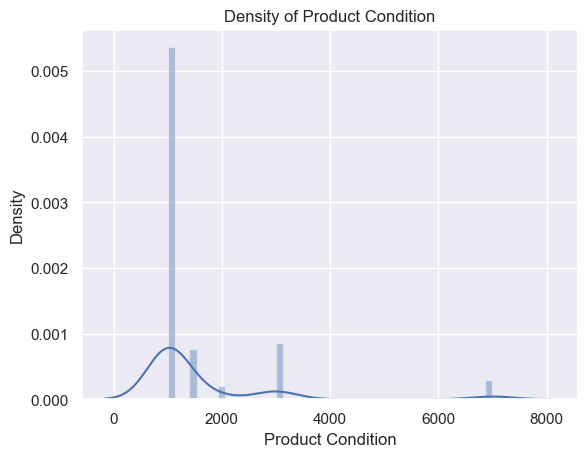

In [19]:
sns.distplot(df['Product Condition']).set(title='Density of Product Condition')
plt.show()

Setting up features and labels

In [20]:
X = df[['Price (in USD)', 'Product Condition', 'Feedback Score', 'Positive Feedback %']].values

In [21]:
Y = df[['Top Rated Seller?']].values

Splitting the Dataset into Training and Test Sets


In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.30, random_state = 0)

In [23]:
X_train

array([[ 925.  , 1500.  ,    4.  ,   83.3 ],
       [ 200.  , 3000.  ,    0.  ,  100.  ],
       [2299.  , 1000.  ,    6.  ,  100.  ],
       ...,
       [2637.27, 1000.  ,  504.  ,   97.5 ],
       [2049.  , 1000.  ,   48.  ,  100.  ],
       [2150.  , 3000.  ,   95.  ,  100.  ]])

In [24]:
'''
#Numbers are too large, standardize
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
'''

'\n#Numbers are too large, standardize\nfrom sklearn.preprocessing import StandardScaler\n\nsc = StandardScaler()\nX_train = sc.fit_transform(X_train)\nX_test = sc.transform(X_test)\n'

In [25]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

In [26]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
#from sklearn.ensemble import RandomForestClassifier #Broke when trying to train
from sklearn import svm

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train.ravel())

#For a list of other distributions, see here: https://scikit-learn.org/stable/modules/naive_bayes.html
gnb = GaussianNB()
gnb.fit(X_train, y_train.ravel())

#Experiment with different SVMs
#linear = svm.SVC(kernel='linear', C=1, decision_function_shape='ovo').fit(X_train, y_train.ravel())
rbf = svm.SVC(kernel='rbf', gamma=1, C=1, decision_function_shape='ovo').fit(X_train, y_train.ravel())
poly = svm.SVC(kernel='poly', degree=3, C=1, decision_function_shape='ovo').fit(X_train, y_train.ravel())
sig = svm.SVC(kernel='sigmoid', C=1, decision_function_shape='ovo').fit(X_train, y_train.ravel())

Performing 5-Fold Cross Validation

In [27]:
#KNN
k = 5
kf = KFold(n_splits=k)

#for other scoring parameters see here https://scikit-learn.org/stable/modules/model_evaluation.html
knn_result = cross_val_score(knn, X_train, y_train.ravel(), cv = kf, scoring='accuracy')

print(f' Avg accuracy: {knn_result.mean()}')

 Avg accuracy: 0.7892857142857143


In [28]:
#GNB
gnb_result = cross_val_score(gnb, X_train, y_train.ravel(), cv = kf, scoring='accuracy')
 
print(f' Avg accuracy:{gnb_result.mean()}')

 Avg accuracy:0.65


In [29]:
'''
#Linear SVM
linear_result = cross_val_score(linear, X_train, y_train.ravel(), cv = kf, scoring='accuracy')

print(f' Avg accuracy:{linear_result.mean()}')
'''

"\n#Linear SVM\nlinear_result = cross_val_score(linear, X_train, y_train.ravel(), cv = kf, scoring='accuracy')\n\nprint(f' Avg accuracy:{linear_result.mean()}')\n"

In [30]:
#RBF SVM
rbf_result = cross_val_score(rbf, X_train, y_train.ravel(), cv = kf, scoring='accuracy')

print(f' Avg accuracy:{rbf_result.mean()}')

 Avg accuracy:0.6535714285714287


In [31]:
#Poly SVM
poly_result = cross_val_score(poly, X_train, y_train.ravel(), cv = kf, scoring='accuracy')

print(f' Avg accuracy:{poly_result.mean()}')

 Avg accuracy:0.6428571428571429


In [32]:
#Sigmoid SVM
sig_result = cross_val_score(sig, X_train, y_train.ravel(), cv = kf, scoring='accuracy')

print(f' Avg accuracy:{sig_result.mean()}')

 Avg accuracy:0.6928571428571428


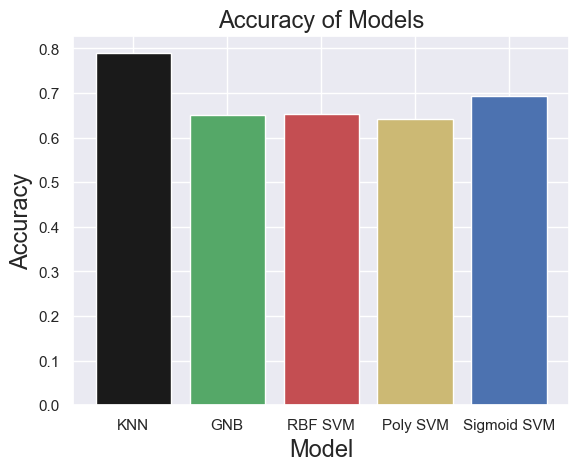

In [35]:
Models = ['KNN', 'GNB', 'RBF SVM', 'Poly SVM', 'Sigmoid SVM']
Accuracy = [knn_result.mean(), gnb_result.mean(), rbf_result.mean(), poly_result.mean(), sig_result.mean()]

#Note - another way of changing the size of the plots
#plt.figure(figsize=(16,9))
#black, green, red, yellow, blue, white
colors = ['k','g','r','y','b','w']

#Note the color parameter value
plt.bar(Models, Accuracy, color = colors)
plt.title('Accuracy of Models',fontsize=17)
plt.xlabel('Model',fontsize=17)
plt.ylabel('Accuracy',fontsize=17)
plt.show()

Making Predictions

In [36]:
# Predicting the Test set results for KNN
y_pred = knn.predict(X_test)

# Predicting the Test set results for GNB
y_pred_gnb = gnb.predict(X_test)

# Getting a set of the Predicted probabilities
probs_y= knn.predict_proba(X_test)

In [37]:
#Creating the probability dataframe
probability = pd.DataFrame(probs_y * 100 , columns =[['Fraudulent(%)', 'Legitimate(%)']])

In [38]:
#Creating a dataframe with the predictions
y_pred_df = pd.DataFrame(y_pred, columns = [['y_pred']])

In [39]:
#Creating a dataframe with the acutal values
y_test_df = pd.DataFrame(y_test, columns = [['y_test']])

In [40]:
#Creating a dataframe with the actual values, the predicted values, and the probabilites which such predictions were made
comparison_of_true_pred = pd.concat([y_test_df, y_pred_df, probability], axis = 1)

In [41]:
comparison_of_true_pred

,y_test,y_pred,Fraudulent(%),Legitimate(%)
0,true,false,80.0,20.0
1,false,false,80.0,20.0
2,false,false,100.0,0.0
3,false,true,40.0,60.0
4,false,false,60.0,40.0
...,...,...,...,...
115,false,false,80.0,20.0
116,false,false,80.0,20.0
117,true,true,0.0,100.0
118,true,true,20.0,80.0


In [42]:
from sklearn.metrics import confusion_matrix

#generating a confusion matrix
confusion_matrix(y_test, y_pred)

array([[64, 18],
       [ 9, 29]])

Classification Report

In [43]:
#KNN
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       false       0.88      0.78      0.83        82
        true       0.62      0.76      0.68        38

    accuracy                           0.78       120
   macro avg       0.75      0.77      0.75       120
weighted avg       0.79      0.78      0.78       120



In [44]:
#GNB
print(classification_report(y_test, y_pred_gnb))

              precision    recall  f1-score   support

       false       0.83      0.72      0.77        82
        true       0.53      0.68      0.60        38

    accuracy                           0.71       120
   macro avg       0.68      0.70      0.68       120
weighted avg       0.74      0.71      0.72       120



In [45]:
'''
#Linear SVM, Currently in beta testing
svm_linear_pred = linear.predict(X_test)

print(classification_report(y_test, svm_linear_pred))
'''

'\n#Linear SVM, Currently in beta testing\nsvm_linear_pred = linear.predict(X_test)\n\nprint(classification_report(y_test, svm_linear_pred))\n'

In [46]:
#Poly SVM
svm_poly_pred = poly.predict(X_test)

print(classification_report(y_test, svm_poly_pred))

              precision    recall  f1-score   support

       false       0.68      0.95      0.80        82
        true       0.33      0.05      0.09        38

    accuracy                           0.67       120
   macro avg       0.51      0.50      0.44       120
weighted avg       0.57      0.67      0.57       120



In [47]:
#Sig SVM
svm_sig_pred = sig.predict(X_test)
print(classification_report(y_test, svm_sig_pred))

              precision    recall  f1-score   support

       false       0.76      0.79      0.78        82
        true       0.51      0.47      0.49        38

    accuracy                           0.69       120
   macro avg       0.64      0.63      0.64       120
weighted avg       0.69      0.69      0.69       120



In [48]:
#RBF SVM
svm_rbf_pred = rbf.predict(X_test)
print(classification_report(y_test, svm_rbf_pred))

              precision    recall  f1-score   support

       false       0.71      1.00      0.83        82
        true       1.00      0.11      0.19        38

    accuracy                           0.72       120
   macro avg       0.85      0.55      0.51       120
weighted avg       0.80      0.72      0.63       120



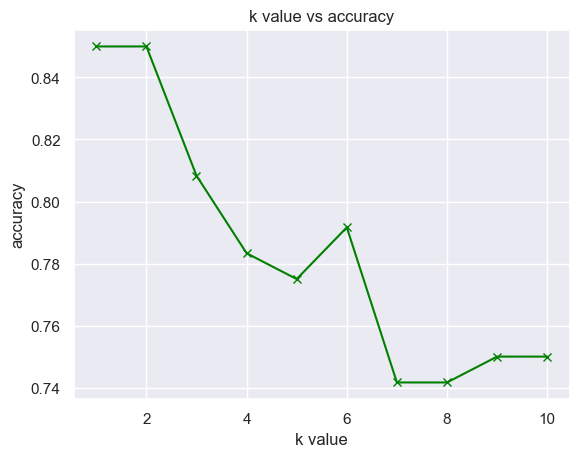

In [49]:
from sklearn.metrics import accuracy_score
accuracy = []

for i in range(1,11):
  knn = KNeighborsClassifier(n_neighbors=i)
  knn.fit(X_train, y_train.ravel())
  y_pred = knn.predict(X_test)
  accuracy.append(accuracy_score(y_test, y_pred.ravel()))
plt.plot(list(range(1,11)), accuracy, color='green', linestyle='solid', marker='x')
plt.xlabel('k value')
plt.ylabel('accuracy')
plt.title('k value vs accuracy')
plt.show()

In [50]:
#Feature Scaling Standardization
sc = StandardScaler()

In [51]:
#Decision Tree Classifier
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
dt.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [52]:
y_pred_dt = dt.predict(X_test)
print(classification_report(y_test, y_pred_dt, target_names = ['positive', 'negative']))

              precision    recall  f1-score   support

    positive       0.89      0.87      0.88        82
    negative       0.72      0.76      0.74        38

    accuracy                           0.83       120
   macro avg       0.81      0.81      0.81       120
weighted avg       0.84      0.83      0.83       120



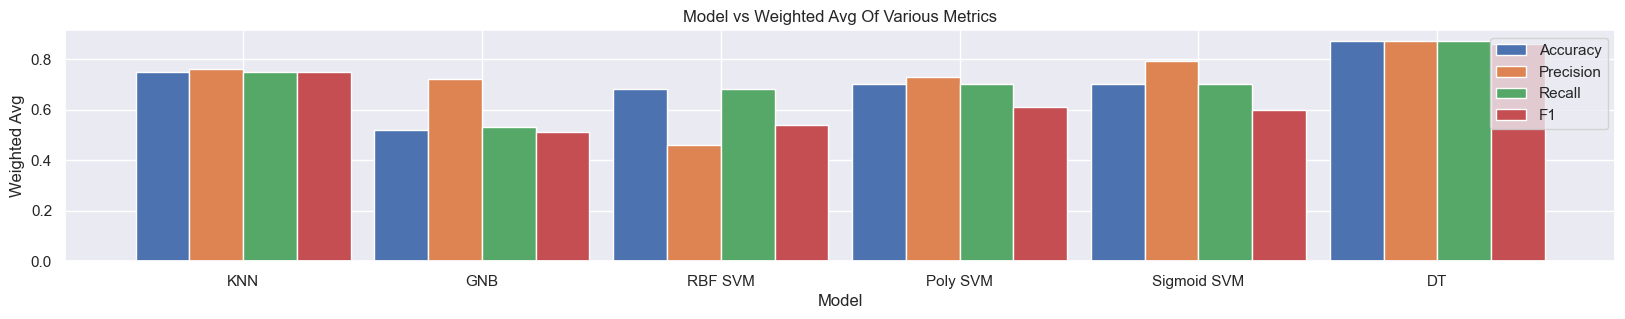

In [53]:
X = ['KNN', 'GNB', 'RBF SVM', 'Poly SVM', 'Sigmoid SVM', 'DT']
accuracy = [0.75, 0.52, 0.68, 0.7, 0.7, 0.87]
precision = [0.76, 0.72, 0.46, 0.73, 0.79, 0.87]
recall = [0.75, 0.53, 0.68, 0.7, 0.7, 0.87]
f1 = [0.75, 0.51, 0.54, 0.61, 0.6, 0.86]

# Number of bars
n_bars = len(X)

# Number of groups of bars (accuracy, precision, recall, f1)
n_groups = 4

# Total width for each group of bars
total_width = 0.9

# Width for each individual bar within a group
bar_width = total_width / n_groups

# Calculate the center positions for each group of bars
X_axis = np.arange(len(X))

# Calculate the left positions for each individual bar within a group
left_positions = X_axis - (total_width - bar_width) / 2

# Setting the size of the graph
plt.rcParams["figure.figsize"] = (20, 3)

# Plotting the bars for each metric using the left positions and respective data
plt.bar(left_positions, accuracy, bar_width, label='Accuracy')
plt.bar(left_positions + bar_width, precision, bar_width, label='Precision')
plt.bar(left_positions + bar_width * 2, recall, bar_width, label='Recall')
plt.bar(left_positions + bar_width * 3, f1, bar_width, label='F1')

# Setting the range of values for the X axis and labels
plt.xticks(X_axis, X)
plt.xlabel("Model")
plt.ylabel("Weighted Avg")
plt.title("Model vs Weighted Avg Of Various Metrics")
plt.legend(loc='upper right')

In [54]:
import pickle
with open('Seller_Detection_Model.pkl', 'wb') as f:
    pickle.dump(gnb, f)
with open('scaler_seller.pkl', 'wb') as f:
    pickle.dump(sc, f)

In [55]:
loaded_model = pickle.load(open('Seller_Detection_Model.pkl', 'rb'))

In [56]:
loaded_model

GaussianNB()

In [64]:
array_ = np.array([2100, 1000, 570, 100]).reshape(1,-1)
print(array_)
accuracy_ = loaded_model.predict_proba(array_)
result = accuracy_[0]
result

[[2100 1000  570  100]]


array([0.51200898, 0.48799102])

In [66]:
labels = ['No', 'Yes']
predicted_label = labels[result.argmax()]
print(predicted_label)
confidence = max(result)
print(round(confidence*100, 2), '%')

No
51.2 %
